In [ ]:
# Feature Analysis of employee turnover using Machine Learning Approach
# Importing the libraries
!pip install shap
#!pip install -q torch==1.0.0 torchvision
#pip install dash
#%pip install lime
#!pip install explainx
#!pip uninstall explainx
#!pip install imblearn
#!pip install --upgrade scikit-learn
#from lime import lime_text
#!pip install pandas
#!pip install --upgrade numpy
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
!pip install smote-variants
import smote_variants as sv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
!pip install dtreeviz

import shap 
#pip install smote-variants
import seaborn as sns
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import accuracy_score
#from keras.utils import np_utils
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
#from dtreeviz.trees import dtreeviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score, f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import lightgbm as lgb
#from sys import exit
from sklearn.utils import class_weight
#from SBSAlgorith_working import SBS
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
#import lime #LIME package
import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns

from torch.utils.data import TensorDataset, random_split, DataLoader
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import tensorflow as tf
from tensorflow import keras
#import lime.lime_tabular #the type of LIIME analysis we’ll do

In [ ]:
def feature_imp(df, model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=True)

In [ ]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

In [ ]:
def build_explainer_on_classifier(classifier, data, explainer = 'Tree'):
    shap_values = None
    if explainer == 'Tree':
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(data)
    else:
        pass
    return explainer, shap_values

def build_explainer_on_KNN(cls, X):
    #f = lambda x: cls.predict_proba(x)[:, 1]
    #med = X.median().values.reshape((1, X.shape[1]))
    #print(X)
    #exit()
    #X_summarized = shap.kmeans(X, k=3)
    X_summary = shap.kmeans(X, 10)
    #print(X_summarized)
    explainer = shap.KernelExplainer(cls.predict,X_summary)
    shap_values = explainer.shap_values(X)

    #explainer = shap.Explainer(f, med)
    #shap_values = explainer(X)

    return explainer, shap_values

In [ ]:
def process_data_for_ml(data):
    #Input: data in tabular format
    #Output: categorical variable mapping and the data
    column_names = data.columns
    numerical_features = []
    categorical_features = []

    actual_categorical_variable = []
    actual_numeric_variable_with_noise = []
    actual_numeric_variable_without_noise = []

    for col in column_names:
        try:
            data[col] = data[col].astype(float)
            numerical_features.append(col)
        except:
            categorical_features.append(col)

    for var in categorical_features:
        numeric_value_count = 0
        categorical_value_count = 0

        for i in data.index:
            try:
                print(float(data.loc[i, var]))
                #print('here')
                numeric_value_count+=1
            except:
                categorical_value_count+=1
        total_data = len(data[var])
        categorical_value_count_percentage = (categorical_value_count / total_data) * 100
        numeric_value_count_percentage = (numeric_value_count / total_data) * 100
        if numeric_value_count_percentage == 100:
            actual_numeric_variable_without_noise.append(var)

        elif numeric_value_count_percentage < 100 and numeric_value_count_percentage >= 90:
            actual_numeric_variable_with_noise.append(var)
        else:
            actual_categorical_variable.append(var)
    numerical_variables = list(set(column_names) - set(actual_categorical_variable))
    label_encoders = dict()
    categorical_mapping = dict()
    for var in actual_categorical_variable:
        label_encoders[var] = preprocessing.LabelEncoder()
        data[var] = label_encoders[var].fit_transform(data[var])
        #print('after_transformation', data[var])
        #print('before_transformation', label_encoders[var].inverse_transform(data[var]))
        #categorical_mapping[var] = dict(zip(label_encoders[var].classes_, label_encoders[var].transform(label_encoders[var].classes_)))
        categorical_mapping[var] = dict(zip(label_encoders[var].transform(label_encoders[var].classes_), label_encoders[var].classes_))
        #print('#################################')
    return categorical_mapping, data

In [ ]:
def build_model(input = None, output = None):
  if (input != None and output != None): 
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(input,)),
        keras.layers.Dense(120, activation=tf.nn.relu,  kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(64, activation = tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dense(output, activation=tf.nn.sigmoid),
    ])
  else:
    print('input and output shape is not defined')
    return None
  #return model
  opt = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
  ) 
  model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
  return model


In [ ]:
df = pd.read_csv('/content/sample_data/Persistent_vs_NonPersistent.csv')
label = 'Persistency_Flag'
####

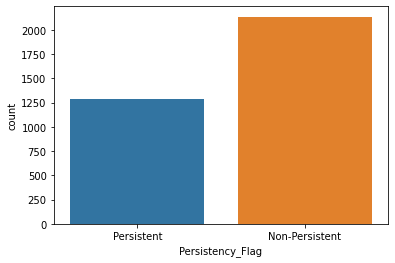

In [ ]:
#exploratory data analysis
sns.countplot(x="Persistency_Flag",data=df, dodge=True)

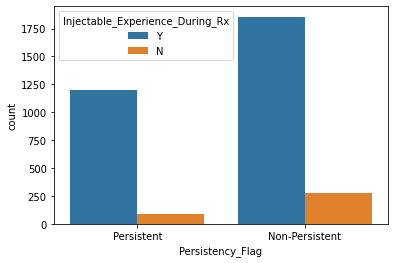

In [ ]:
sns.countplot(x="Persistency_Flag",hue='Injectable_Experience_During_Rx', data=df)

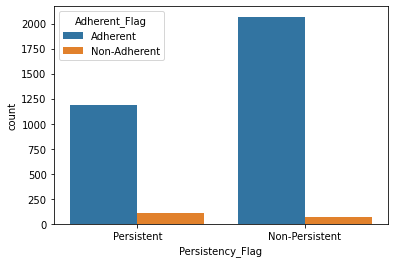

In [ ]:
sns.countplot(x='Persistency_Flag', hue = 'Adherent_Flag', data = df)

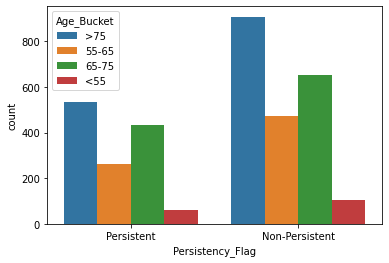

In [ ]:
sns.countplot(x="Persistency_Flag", hue='Age_Bucket', data=df)

In [ ]:
cat_dict, data = process_data_for_ml(df)

X = data.drop(label , axis = 1) #independent Feature
y = data[label] #dependent Feature

print(cat_dict)

{'Ptid': {0: 'P1', 1: 'P10', 2: 'P100', 3: 'P1000', 4: 'P1001', 5: 'P1002', 6: 'P1003', 7: 'P1004', 8: 'P1005', 9: 'P1006', 10: 'P1007', 11: 'P1008', 12: 'P1009', 13: 'P101', 14: 'P1010', 15: 'P1011', 16: 'P1012', 17: 'P1013', 18: 'P1014', 19: 'P1015', 20: 'P1016', 21: 'P1017', 22: 'P1018', 23: 'P1019', 24: 'P102', 25: 'P1020', 26: 'P1021', 27: 'P1022', 28: 'P1023', 29: 'P1024', 30: 'P1025', 31: 'P1026', 32: 'P1027', 33: 'P1028', 34: 'P1029', 35: 'P103', 36: 'P1030', 37: 'P1031', 38: 'P1032', 39: 'P1033', 40: 'P1034', 41: 'P1035', 42: 'P1036', 43: 'P1037', 44: 'P1038', 45: 'P1039', 46: 'P104', 47: 'P1040', 48: 'P1041', 49: 'P1042', 50: 'P1043', 51: 'P1044', 52: 'P1045', 53: 'P1046', 54: 'P1047', 55: 'P1048', 56: 'P1049', 57: 'P105', 58: 'P1050', 59: 'P1051', 60: 'P1052', 61: 'P1053', 62: 'P1054', 63: 'P1055', 64: 'P1056', 65: 'P1057', 66: 'P1058', 67: 'P1059', 68: 'P106', 69: 'P1060', 70: 'P1061', 71: 'P1062', 72: 'P1063', 73: 'P1064', 74: 'P1065', 75: 'P1066', 76: 'P1067', 77: 'P1068'

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
X_train,X_test,y_train,y_test = train_test_split(X,y , test_size =0.2,random_state=42)
print(X_train.columns)

Index(['Ptid', 'Gender', 'Race', 'Ethnicity', 'Region', 'Age_Bucket',
       'Ntm_Speciality', 'Ntm_Specialist_Flag', 'Ntm_Speciality_Bucket',
       'Gluco_Record_Prior_Ntm', 'Gluco_Record_During_Rx',
       'Dexa_Freq_During_Rx', 'Dexa_During_Rx', 'Frag_Frac_Prior_Ntm',
       'Frag_Frac_During_Rx', 'Risk_Segment_Prior_Ntm',
       'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx',
       'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment',
       'Adherent_Flag', 'Idn_Indicator', 'Injectable_Experience_During_Rx',
       'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms',
       'Comorb_Encounter_For_Immunization',
       'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx',
       'Comorb_Vitamin_D_Deficiency',
       'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified',
       'Comorb_Encntr_For_Oth_Sp_Exam_W_O_Complaint_Suspected_Or_Reprtd_Dx',
       'Comorb_Long_Term_Current_Drug_Therapy', 'Comorb_Dorsalgia',
       'Comorb_Personal_History

TESTING RESULTS: 
CONFUSION MATRIX:
[[379  52]
 [ 83 171]]
ACCURACY SCORE:
0.8029


Text(0.5, 1.0, 'Feature Importance according to RFC')

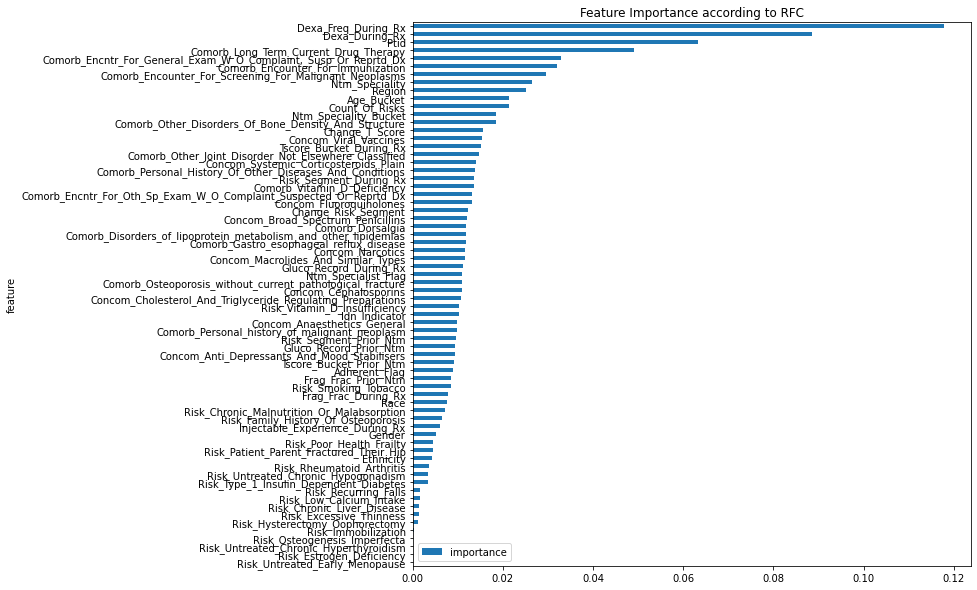

In [ ]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(max_depth=500, random_state=0)
cls.fit(X_train,y_train)

y_pred_test = cls.predict(X_test)
#to_save = pd.DataFrame(np.c_[y_test, y_pred_test], columns=['y_test', 'y_pred'])
#to_save.to_excel('/content/sample_data/prediction_result.xlsx', index=False)
print("TESTING RESULTS: \n===============================")
clf_report = pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True))
print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_pred_test)}")
print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_pred_test):.4f}")
#print(f"CLASSIFICATION REPORT:\n{clf_report}")

features = X_train.columns
label_names = cat_dict[label].keys()

df = feature_imp(X_test, cls)[:]
df.set_index('feature', inplace=True)
#print(df)
df.plot(kind='barh', figsize=(10, 10))
plt.title('Feature Importance according to RFC')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


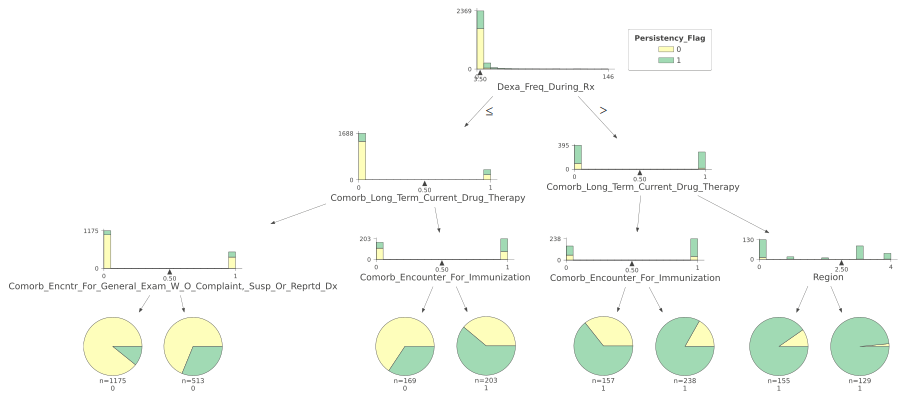

In [ ]:
from sklearn.datasets import *
from sklearn import tree
#!pip install dtreeviz  
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import numpy as np

classifier = tree.DecisionTreeClassifier(max_depth=3)  # limit depth of tree
#iris = load_iris()
classifier.fit(X_train, y_train)
X = X_test.sample(n=1)
viz = dtreeviz(classifier, 
               X_train, 
               y_train,
               target_name='Persistency_Flag',
               feature_names=X_train.columns, 
               class_names=list(y_train.unique()),  # need class_names for classifier
              )  
              
viz

correct prediction on test 550
wrong prediction on test 135


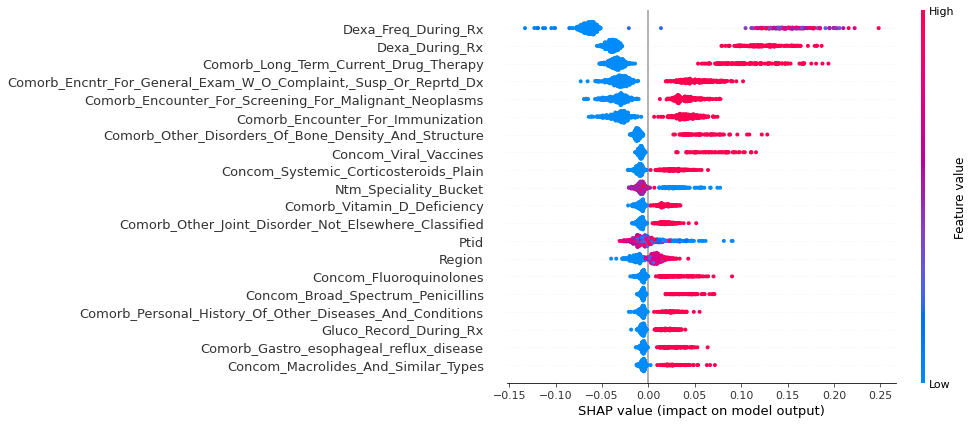

In [ ]:
explainer, shap_values = build_explainer_on_classifier(cls, X_test)

wrong_prediction = [ i for i in range(len(y_test.values)) if y_test.values[i]!=y_pred_test[i]]
correct_prediction = [ i for i in range(len(y_test.values)) if y_test.values[i]==y_pred_test[i]]
print('correct prediction on test', len(correct_prediction))
print('wrong prediction on test', len(wrong_prediction))

shap.initjs()
#shap.summary_plot(shap_values, X_test)

#shap.summary_plot(shap_values[1], X_test.values, feature_names = X_test.columns)
#shap.summary_plot(shap_values[1][wrong_prediction,:], X_test.values[wrong_prediction,:], feature_names = X_test.columns)
shap.summary_plot(shap_values[1][correct_prediction,:], X_test.values[correct_prediction,:], feature_names = X_test.columns,  plot_size=[14,6])

In [ ]:
correctly_predicted_test = X_test.values[correct_prediction,:]
correctly_predicted_test_df = pd.DataFrame(correctly_predicted_test, columns = X_test.columns)

explainer_correct_prediction, shap_values_correctly_predicted = build_explainer_on_classifier(cls, correctly_predicted_test_df)
#correctly_predicted_test.columns = X_test.columns

import numpy as np
vals= np.abs(shap_values_correctly_predicted).mean(0)

feature_importance = pd.DataFrame(list(zip(correctly_predicted_test_df.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
important_features = feature_importance.head(20)['col_name'].unique()


In [ ]:
print('the most important features are sorted: ', important_features)

the most important features are sorted:  ['Dexa_Freq_During_Rx' 'Dexa_During_Rx'
 'Comorb_Long_Term_Current_Drug_Therapy'
 'Comorb_Encntr_For_General_Exam_W_O_Complaint,_Susp_Or_Reprtd_Dx'
 'Comorb_Encounter_For_Screening_For_Malignant_Neoplasms'
 'Comorb_Encounter_For_Immunization'
 'Comorb_Other_Disorders_Of_Bone_Density_And_Structure'
 'Concom_Viral_Vaccines' 'Concom_Systemic_Corticosteroids_Plain'
 'Ntm_Speciality_Bucket' 'Comorb_Vitamin_D_Deficiency'
 'Comorb_Other_Joint_Disorder_Not_Elsewhere_Classified' 'Ptid' 'Region'
 'Concom_Fluoroquinolones' 'Concom_Broad_Spectrum_Penicillins'
 'Comorb_Personal_History_Of_Other_Diseases_And_Conditions'
 'Gluco_Record_During_Rx' 'Comorb_Gastro_esophageal_reflux_disease'
 'Concom_Macrolides_And_Similar_Types']


In [ ]:
input_features = X_train.shape[1]
out_features = len(np.unique(y_train))

In [ ]:
#If you want to use important features
X_train_ = X_train[important_features]
X_test_ = X_test[important_features]

In [ ]:
model = build_model(input = X_train.shape[1], output = 1)
model.fit(X_train, y_train, validation_split=0.1 ,epochs=500, batch_size=128, verbose = 2)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

Epoch 1/500
20/20 - 2s - loss: 6.0989 - accuracy: 0.5233 - val_loss: 6.7889 - val_accuracy: 0.6022 - 2s/epoch - 81ms/step
Epoch 2/500
20/20 - 0s - loss: 3.2769 - accuracy: 0.5477 - val_loss: 1.1980 - val_accuracy: 0.6569 - 136ms/epoch - 7ms/step
Epoch 3/500
20/20 - 0s - loss: 2.5467 - accuracy: 0.5436 - val_loss: 7.6106 - val_accuracy: 0.3942 - 130ms/epoch - 6ms/step
Epoch 4/500
20/20 - 0s - loss: 4.2916 - accuracy: 0.5318 - val_loss: 5.4378 - val_accuracy: 0.6168 - 146ms/epoch - 7ms/step
Epoch 5/500
20/20 - 0s - loss: 3.1365 - accuracy: 0.5529 - val_loss: 1.9652 - val_accuracy: 0.6387 - 144ms/epoch - 7ms/step
Epoch 6/500
20/20 - 0s - loss: 1.1863 - accuracy: 0.6146 - val_loss: 0.6885 - val_accuracy: 0.7445 - 126ms/epoch - 6ms/step
Epoch 7/500
20/20 - 0s - loss: 0.9295 - accuracy: 0.6446 - val_loss: 1.6694 - val_accuracy: 0.6569 - 145ms/epoch - 7ms/step
Epoch 8/500
20/20 - 0s - loss: 1.1625 - accuracy: 0.6519 - val_loss: 0.6105 - val_accuracy: 0.8029 - 174ms/epoch - 9ms/step
Epoch 9/50

[[375  56]
 [ 82 172]]
0.7985401459854015


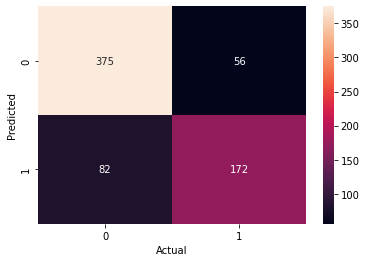

In [ ]:
#predictions = []
y_pred = model.predict(X_test)
y_pred = [1 if y_pred[i]>=0.5 else 0 for i in range(0,len(y_pred))]
cm = confusion_matrix(y_test,y_pred)
print(cm)
sns.heatmap(cm,annot=True, fmt = 'd')
plt.xlabel('Actual')
plt.ylabel('Predicted')

#Accuracy
score = accuracy_score(y_test , y_pred)
print(score)